### Random Forest ... but make it with the EOFs because I can lol. 

7/23/2025

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

In [2]:
##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import definitions from skill stat file
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS
from SkillStats_MOD import PAS

In [4]:
idx = 135
#switch to 149 for normal. 

In [5]:
shift = 14
#0 if normal
#this indicates setting the start date as November 2 rather than October 19

In [6]:
#load input data
infile = open("../../REAL/reduced_data/PCs/U_14.p","rb",)
U_PC = pickle.load(infile)  ##pv on an isentropic surface, 350
U_PC = U_PC.reshape(62,149,10)
infile.close()

infile = open("../../REAL/reduced_data/PCs/EHF_14.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
EHF_PC = EHF_PC.reshape(62,149,45)
infile.close()

infile = open("../../REAL/reduced_data/PCs/GPH_14.p","rb",)
GPH_PC = pickle.load(infile)  
GPH_PC = GPH_PC.reshape(62,149,10)
infile.close()

##remove PC 1
U_PC = U_PC[:, shift:, 1:]
EHF_PC = EHF_PC[:, shift:, 1:]
GPH_PC = GPH_PC[:, shift:, 1:]

U_PC.shape

(62, 135, 9)

In [8]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=2) 
inp1 = inputvar.reshape((62*idx),62)

##make pandas dataframe for RF
inp = pd.DataFrame(inp1)

#create pd datafram of selected feature columns.
inp = inp[[1, 56, 0, 54, 9, 57, 2, 31, 26, 14, 20, 6, 11, 38, 21, 18, 15, 22, 12, 13]]
#label columns of variables for input data
col_names = ['U3', 'GPH4', 'U2', 'GPH2', 'EHF2', 'GPH5', 'U4', 'EHF24', 'EHF19', 'EHF7',
            'EHF13', 'U8', 'EHF4', 'EHF31', 'EHF14', 'EHF11', 'EHF8', 'EHF15', 'EHF5', 'EHF6']

inp.columns = col_names
inp

,U3,GPH4,U2,GPH2,EHF2,GPH5,U4,EHF24,EHF19,EHF7,EHF13,U8,EHF4,EHF31,EHF14,EHF11,EHF8,EHF15,EHF5,EHF6
0,-1.186052,1.401645,0.752621,0.209807,0.027478,0.018301,0.333147,-1.238869,-0.566598,0.375148,0.114243,0.467725,-0.196677,-0.048604,-1.407014,-0.003502,-0.144331,0.169488,-0.005603,0.307784
1,-1.252295,1.508203,0.767788,0.393342,0.026738,-0.175079,0.054316,-1.555307,-1.015816,0.402462,-1.206520,0.411638,-0.122714,-0.316326,-1.194313,0.396331,-0.113486,-0.119404,0.095775,0.173497
2,-1.341869,1.354320,0.850664,0.672118,0.052752,-0.119300,-0.086885,0.100384,0.062058,0.367632,-1.009713,0.588128,-0.130009,0.284854,0.358146,-0.365585,-0.240902,-0.346428,0.181739,0.142555
3,-1.400461,1.396061,0.814725,0.783787,0.153233,0.056179,-0.210343,0.446200,0.370710,0.425922,0.284332,0.725755,-0.064082,0.098467,0.163162,-0.705649,-0.415141,0.130562,0.279532,0.223443
4,-1.462145,1.371293,0.738818,0.786336,0.215701,0.308007,-0.268501,0.696554,-0.047688,0.279267,0.409636,1.239921,0.012594,0.190916,-0.208728,-0.345254,-0.518787,0.394408,0.322096,0.105504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8365,0.344881,-0.931433,0.739117,1.871430,-0.032577,-0.594206,-1.039941,-0.509073,-0.257606,-0.355304,-0.337902,1.955351,0.696732,-0.993664,-0.459643,-0.780476,0.085641,0.103523,1.020420,-0.827579
8366,0.610486,-0.883960,0.708051,1.945315,0.100459,-0.255287,-0.735913,-0.484002,0.104951,-0.734529,-0.387806,2.091698,0.528793,-0.712909,0.187002,-0.496463,-0.079321,0.201060,0.726277,-0.338853
8367,0.813433,-1.013030,0.612392,1.904598,0.138989,-0.031661,-0.491388,-0.967253,-0.227728,-0.252240,-0.915382,2.458308,0.276310,0.378725,0.115268,-0.112195,0.129463,-0.507578,0.114448,0.129632
8368,0.300776,-1.099654,0.179745,1.709359,0.101430,-0.021087,-0.592462,-1.556661,-0.148204,0.084979,-2.017825,1.450899,0.127205,0.196277,0.509032,0.827147,0.147253,-0.492190,0.008271,0.058502


In [9]:
#load output data file.
#I can change this to represent any of the available temp regions. 
infile = open("../data/eur_anomtemps_reduced.p","rb",)
temp = pickle.load(infile) 
infile.close()

# load climo data
infile = open("../data/eur_climoprob_reduced.p","rb",)
climo = pickle.load(infile) 
infile.close()

In [10]:
print(temp.shape)
print(climo.shape)

(9238,)
(9238, 2)


In [11]:
temp = temp.reshape(62,149) ##it was flattened, reshape it
climo = climo.reshape(62,149,2)

In [12]:
##reshape again to introduce lag. 
output = temp[:,shift:].reshape(62*idx)
output.shape

(8370,)

In [13]:
##reshaping climo
climo = climo[:,shift:,:].reshape(62*idx,2)
climo.shape

(8370, 2)

In [14]:
output[0:20]

array([1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0.])

### Start Random Forest Model. 

In [15]:
##first ... split data into training/testing ...
##this is just taking the first 58 years of data, leaving the remaining 5 for testing
X_train = inp.iloc[:(52*idx),:]
X_test = inp.iloc[(52*idx):,:]
Y_train = output[:(52*idx)]
Y_test = output[(52*idx):]

val_subset = (10*idx) #index for subsetting validation data in cross val

In [16]:
X_train.describe()

,U3,GPH4,U2,GPH2,EHF2,GPH5,U4,EHF24,EHF19,EHF7,EHF13,U8,EHF4,EHF31,EHF14,EHF11,EHF8,EHF15,EHF5,EHF6
count,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000,7020.000000
mean,0.136890,-0.155964,-0.043395,-0.047829,0.002735,-0.065971,-0.107266,0.001246,-0.015183,0.006561,-0.014003,-0.087908,0.010261,-0.000192,0.019070,0.030307,0.002022,-0.016633,0.001662,-0.025556
std,0.915184,0.898599,1.042217,1.016813,1.024621,1.015980,0.973055,1.025215,1.028606,1.036236,1.021454,0.971420,1.016370,1.024832,1.029836,1.023088,1.025133,1.018889,1.000869,1.033261
min,-2.330901,-3.385422,-3.722318,-3.453941,-5.644896,-4.587965,-3.277297,-4.416084,-7.250258,-4.508757,-5.269061,-3.519752,-9.590916,-7.026523,-5.584905,-7.551976,-9.831314,-5.088114,-6.483733,-6.048667
25%,-0.538224,-0.757411,-0.828523,-0.716830,-0.471251,-0.687391,-0.789768,-0.589327,-0.539445,-0.487114,-0.594844,-0.759829,-0.415736,-0.466632,-0.609614,-0.532590,-0.392148,-0.564217,-0.430135,-0.510797
50%,0.156188,-0.158145,0.005295,0.001731,-0.001661,-0.044677,-0.087615,0.000429,-0.006759,-0.050709,0.027036,-0.089450,0.034990,0.011031,-0.012936,-0.006851,0.004418,-0.059391,0.010093,0.031766
75%,0.784997,0.472534,0.752504,0.641659,0.388984,0.576937,0.566832,0.594545,0.548304,0.373760,0.606279,0.557022,0.471302,0.478167,0.628288,0.576849,0.430484,0.459110,0.436346,0.458258
max,3.336169,2.464505,3.271427,3.099698,5.523659,3.512782,3.169371,5.693684,5.225410,9.546534,4.214322,3.705687,5.137964,8.432438,5.055216,5.431998,6.726635,5.261486,7.119503,6.085674


In [17]:
##next are some empty lists, as I love to do lol. 
n = 100

In [18]:
#empty lists to save Accuracy
acc_reg1_val = []
acc_reg1_train = []
acc_reg1_test = []

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))

important = np.empty((n,20))

In [19]:
#save probabilities
p_test = []
p_train = []
p_val = []

In [20]:
#create initial regressor for rf to do feature selection 
rf_reg1 = RandomForestClassifier(max_depth=3, n_estimators=400, random_state=42)

In order for me to add in the appropriate skill scores, since this is a categorical classification, I had to create separate metrics with one hot encoding to calculate BSS/RAS/PAS. 

I also had to calculate the daily probability for each categorical classification, which is done in the temperature pre-processing file. 

In [21]:
##one-hot encoded outputs for the purpose of calculating probabilities
import keras
Y_all = keras.utils.to_categorical(output)
Y_tes = keras.utils.to_categorical(Y_test)
X_all = inp.values

2025-07-24 00:04:48.613333: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 00:04:48.617298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 00:04:48.667441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 00:04:48.667488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 00:04:48.667523: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [22]:
Y_all

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [23]:
##make loop for cross validation 
for l in range(0,n):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train.iloc[:,0])-val_subset)
    end = start+(val_subset)

    climo_test = climo[(52*idx):,:]
    climo_tr = climo[:(52*idx),:]
    
    X_val = inp.iloc[start:end,:]
    Y_val = output[start:end]
    climo_val = climo_tr[start:end,:]
    
    X_train1 = X_train.iloc[0:start]
    Y_train1 = Y_train[0:start]
    climo_train1 = climo_tr[0:start,:]
    X_train2 = X_train.iloc[end:]
    Y_train2 = Y_train[end:]
    climo_train2 = climo_tr[end:,:]

    ##concatenate all of these
    X_tr = pd.concat([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))
    climo_train = np.concatenate((climo_train1,climo_train2))
    

    #_______________________train the model_______________________________
    #train rf
    rf_reg1.fit(X_tr, Y_tr)
    pred1 = rf_reg1.predict(X_all)
    pred2 = rf_reg1.predict_proba(X_all)
    
    #prediction with validation data
    pred_val1 = rf_reg1.predict(X_val)
    pred_val2 = rf_reg1.predict_proba(X_val)
    p_val.append(pred_val2)
    acc_reg1_val.append(accuracy_score(Y_val, pred_val1))
    
    #prediction with training data
    pred_train1 = rf_reg1.predict(X_tr)
    pred_train2 = rf_reg1.predict_proba(X_tr)
    p_train.append(pred_train2)
    acc_reg1_train.append(accuracy_score(Y_tr, pred_train1))

    #prediction with testing data
    pred_test1 = rf_reg1.predict(X_test)
    pred_test2 = rf_reg1.predict_proba(X_test)
    p_test.append(pred_test2)
    acc_reg1_test.append(accuracy_score(Y_test, pred_test1))
   
    #_______________________feature selection______________________________
    #prepare to show relevant features by actually ... choosing them 
    selector = SelectFromModel(rf_reg1, threshold="mean", max_features=None)
    X_train_selected = selector.transform(X_tr)
    X_test_selected = selector.transform(X_test)

    #print names of selected features
    selected_features = inp.columns[selector.get_support()]
    print(f'Selected Features: {selected_features}')

    importances = rf_reg1.feature_importances_
    important[l,:] = importances[:]
    
    #_______________________statistics calcs_______________________________
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    
    Y_tr2 = keras.utils.to_categorical(Y_tr)
    Y_val2 = keras.utils.to_categorical(Y_val)

    ##BRIER SKILL SCORE
    BSS_all[l] = BSS(Y_all,pred2)
    BSS_val[l] = BSS(Y_val2,pred_val2)
    BSS_train[l] = BSS(Y_tr2,pred_train2)
    BSS_test[l] = BSS(Y_tes,pred_test2) 
    
    ##RECALL ACCURACY SCORE    
    RAS(l, Rec_all, climo, Y_all, pred2, pred_class,
            climo_val, Rec_val, Y_val2, pred_val2, predval_class,
            climo_train, Rec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test2, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS(l, Prec_all, climo, Y_all, pred2, pred_class,
            climo_val, Prec_val, Y_val2, pred_val2, predval_class,
            climo_train, Prec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test2, predtest_class)

Cross Val #:0
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:1
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:2
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2', 'EHF24'], dtype='object')
Cross Val #:3
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:4
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:5
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2', 'GPH5'], dtype='object')
Cross Val #:6
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2', 'GPH5', 'EHF24'], dtype='object')
Cross Val #:7
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:8
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:9
Selected Features: Index(['U3', 'GPH4', 'U2', 'GPH2', 'EHF2'], dtype='object')
Cross Val #:10
Selected Features: In

In [24]:
print('###################################################')
print(f'Accuracy, Validation: {np.mean(acc_reg1_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg1_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg1_test) * 100:.2f}%')

###################################################
Accuracy, Validation: 59.73%
Accuracy, Training: 63.86%
Accuracy, Testing: 59.70%


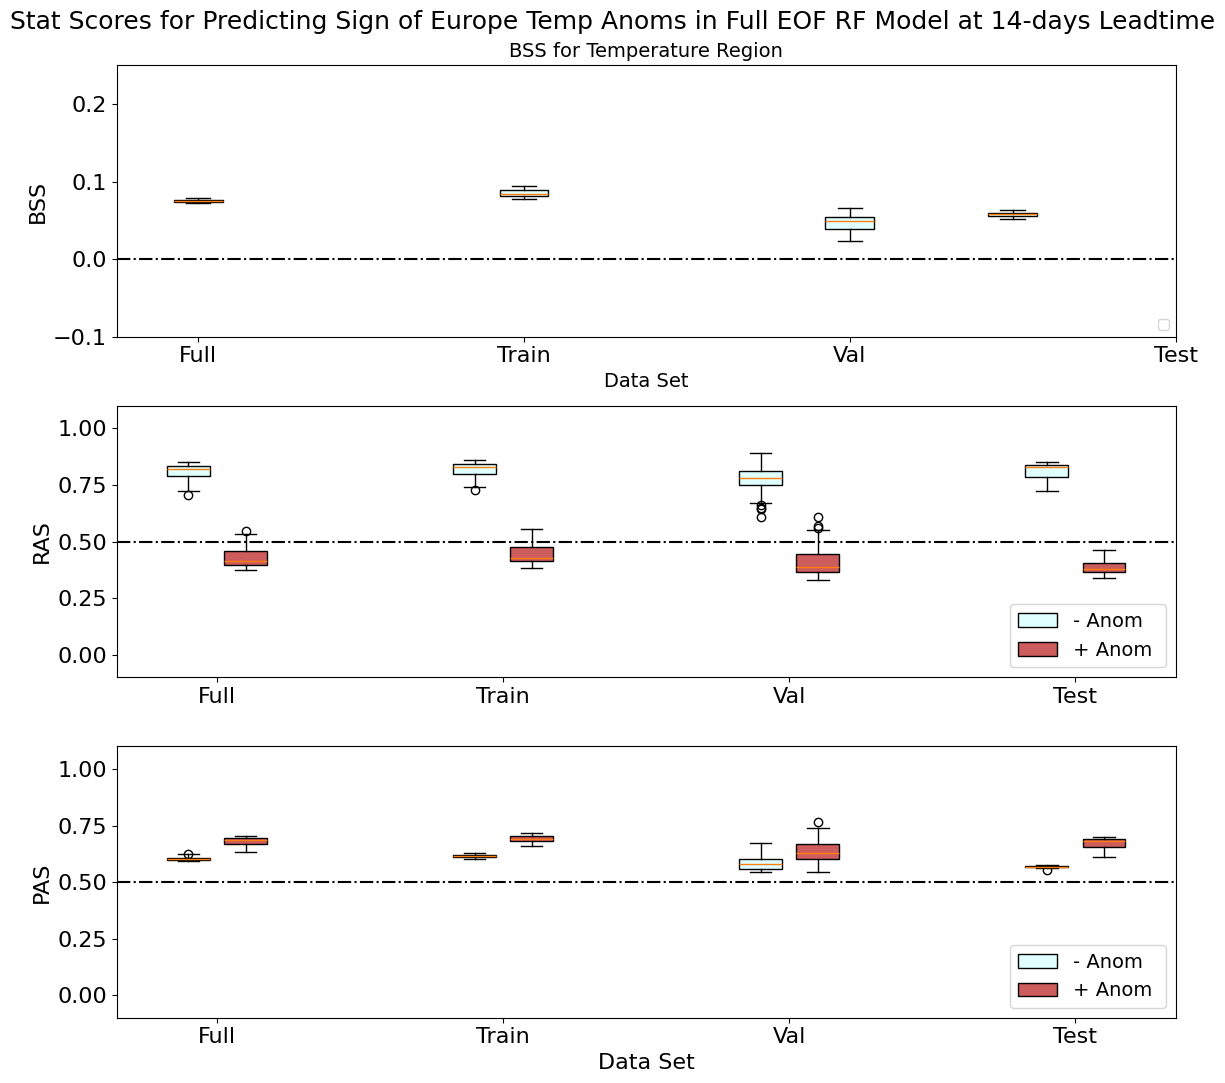

In [25]:
#plot
fig = plt.figure(figsize=(12,11))
font = 16
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','indianred']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.3 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
plt.suptitle("Stat Scores for Predicting Sign of Europe Temp Anoms in Full EOF RF Model at 14-days Leadtime",fontsize = 18) 

a1_0 = ax1.boxplot(BSS_all[:], positions= [2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot(BSS_train[:], positions=[4], widths=w, patch_artist=True)
a1_10 = ax1.boxplot(BSS_val[:], positions=[6], widths=w, patch_artist=True)
a1_14 = ax1.boxplot(BSS_test[:], positions=[7], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#for patch, label in zip(a1_0['boxes'], labels):
    #patch.set_label(label)
ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-0.1,0.25)
ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 10)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 14)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 14)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("./images/FullEOFRF_14days_EurSS.png", bbox_inches='tight',dpi =150)


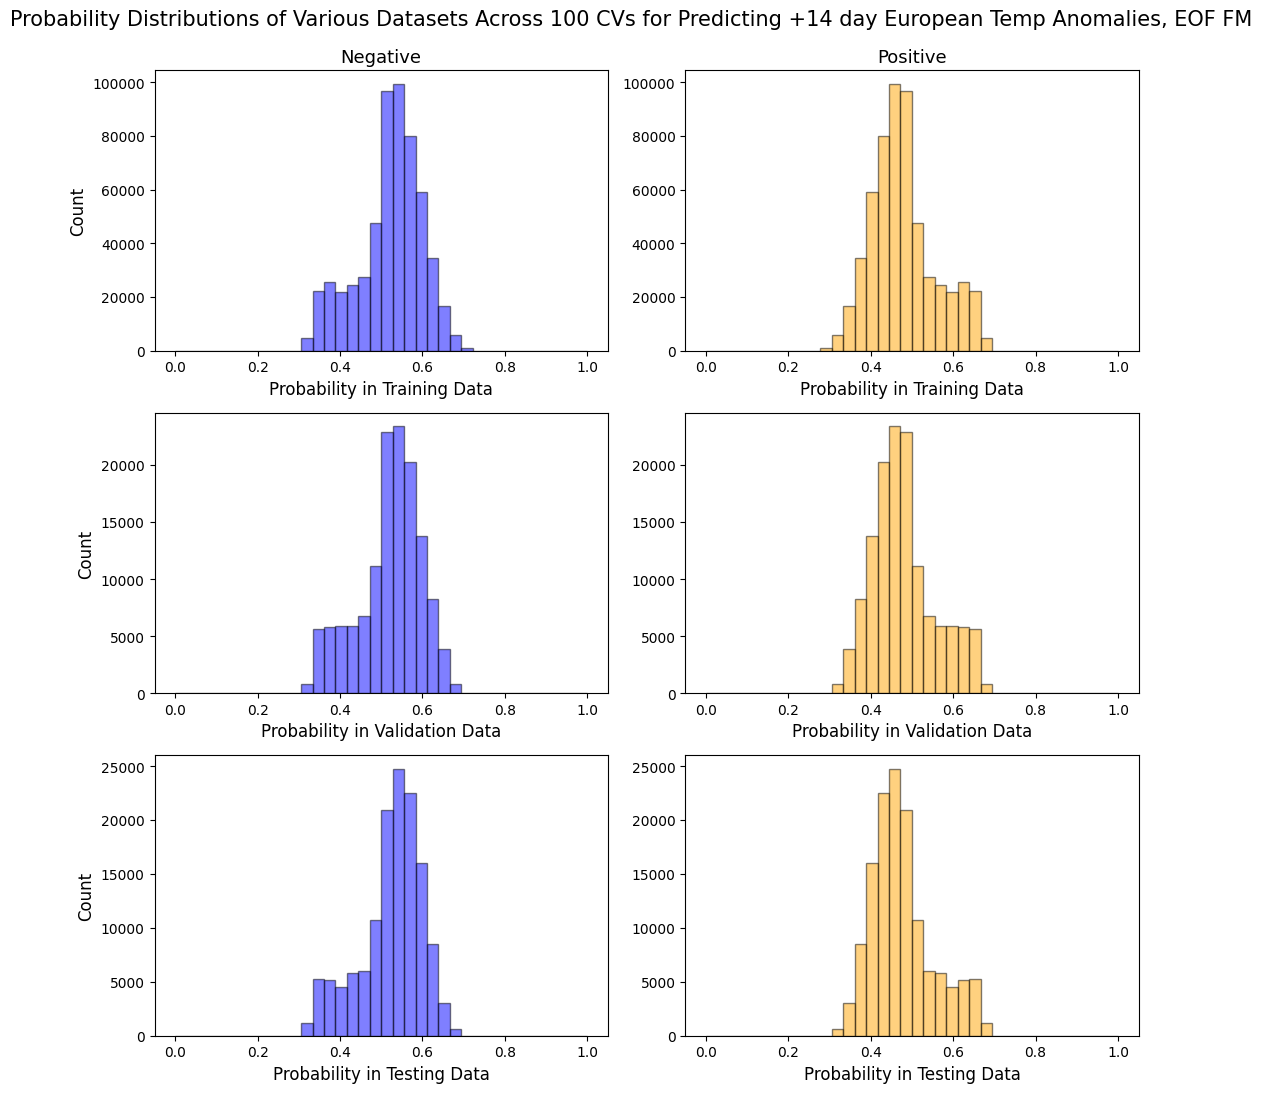

In [26]:
p_test = np.array(p_test)
p_test = p_test.reshape((len(p_test)*len(p_test[0]),2))

p_train = np.array(p_train)
p_train = p_train.reshape((len(p_train)*len(p_train[0]),2))

p_val= np.array(p_val)
p_val = p_val.reshape((len(p_val)*len(p_val[0]),2))

bins = np.linspace(0, 1, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_val[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_test[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in Training Data', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in Training Data', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Validation Data', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Validation Data', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in Testing Data', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in Testing Data', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions of Various Datasets Across 100 CVs for Predicting +14 day European Temp Anomalies, EOF FM", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
plt.savefig("./images/EurEOFRF_probdistrib_14days.png",bbox_inches = 'tight')

In [27]:
#take average across all feature importance values by cross validation
imp = np.nanmean(important, axis = 0)
imp.shape

(20,)

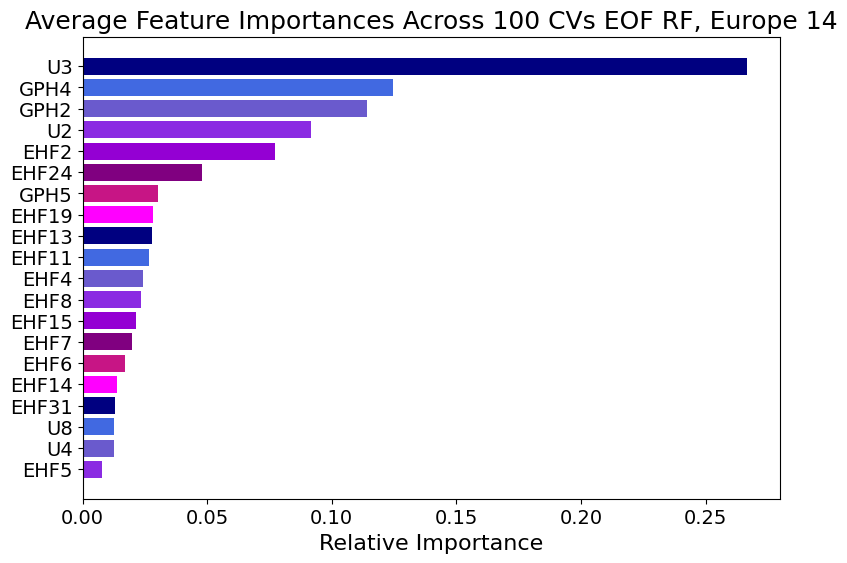

In [28]:
#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across 100 CVs EOF RF, Europe 14",fontsize =18)
plt.barh(range(inp.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(inp.shape[1]), inp.columns[indices],fontsize =14)
plt.xticks(fontsize =14)
plt.xlabel("Relative Importance",fontsize =16)
plt.gca().invert_yaxis()
plt.savefig("./images/EurEOFRF_FeatureImportance_14days.png",bbox_inches = 'tight')

### Switch over to the reduced model. 

In [29]:
##change pandas dataframe to choose top 3 important features only
input2 = inp[['U3', "GPH4", "GPH2","U2","EHF2","EHF24"]]
#input2 = input

In [30]:
#AGAIN, empty lists 
n = 100
#empty lists to save Accuracy
acc_reg2_val = []
acc_reg2_train = []
acc_reg2_test = []

##BSS Arrays
##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))

important = np.empty((n,8))

#save PREDICTIONS
test90_acc = []
##full model
fulltest_acc = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

indexes = []

##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

#save probabilities
p_test = []
p_train = []
p_val = []

In [31]:
##first ... split data into training/testing ...
##this is just taking the first 58 years of data, leaving the remaining 5 for testing
X_train = input2.iloc[:(52*idx),:]
X_test = input2.iloc[(52*idx):,:]
Y_train = output[:(52*idx)]
Y_test = output[(52*idx):]

val_subset = (10*idx) #index for subsetting validation data in cross val

In [32]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [33]:
Y_all = keras.utils.to_categorical(output)
Y_tes = keras.utils.to_categorical(Y_test)
X_all = input2.values

In [34]:
#second random forest model with selected features only
rf_reg2 = RandomForestClassifier(max_depth=3, n_estimators=400, random_state=42)

In [35]:
##make loop for cross validation 
for l in range(0,n):
    print("Cross Val #:"+str(l))
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_train.iloc[:,0])-val_subset)
    end = start+(val_subset)

    climo_test = climo[(52*idx):,:]
    climo_tr = climo[:(52*idx),:]
    
    X_val = input2.iloc[start:end,:]
    Y_val = output[start:end]
    climo_val = climo_tr[start:end,:]
    
    X_train1 = X_train.iloc[0:start]
    Y_train1 = Y_train[0:start]
    climo_train1 = climo_tr[0:start,:]
    X_train2 = X_train.iloc[end:]
    Y_train2 = Y_train[end:]
    climo_train2 = climo_tr[end:,:]

    ##concatenate all of these
    X_tr = pd.concat([X_train1,X_train2], axis = 0)
    Y_tr = np.concatenate((Y_train1,Y_train2))
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    
    #_______________________train the model_______________________________
    #train rf
    rf_reg2.fit(X_tr, Y_tr)
    pred1 = rf_reg2.predict(X_all)
    pred2 = rf_reg2.predict_proba(X_all)
    
    #prediction with validation data
    pred_val1 = rf_reg2.predict(X_val)
    pred_val2 = rf_reg2.predict_proba(X_val)
    p_val.append(pred_val2)
    acc_reg2_val.append(accuracy_score(Y_val, pred_val1))
    
    #prediction with training data
    pred_train1 = rf_reg2.predict(X_tr)
    pred_train2 = rf_reg2.predict_proba(X_tr)
    p_train.append(pred_train2)
    acc_reg2_train.append(accuracy_score(Y_tr, pred_train1))

    #prediction with testing data
    pred_test1 = rf_reg2.predict(X_test)
    pred_test2 = rf_reg2.predict_proba(X_test)
    p_test.append(pred_test2)
    acc_reg2_test.append(accuracy_score(Y_test, pred_test1))
    
    #_______________________statistics calcs_______________________________
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []

    Y_tr2 = keras.utils.to_categorical(Y_tr)
    Y_val2 = keras.utils.to_categorical(Y_val)

    ##BRIER SKILL SCORE
    BSS_all[l] = BSS(Y_all,pred2)
    BSS_val[l] = BSS(Y_val2,pred_val2)
    BSS_train[l] = BSS(Y_tr2,pred_train2)
    BSS_test[l] = BSS(Y_tes,pred_test2) 
    
    ##RECALL ACCURACY SCORE    
    RAS(l, Rec_all, climo, Y_all, pred2, pred_class,
            climo_val, Rec_val, Y_val2, pred_val2, predval_class,
            climo_train, Rec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test2, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS(l, Prec_all, climo, Y_all, pred2, pred_class,
            climo_val, Prec_val, Y_val2, pred_val2, predval_class,
            climo_train, Prec_train, Y_tr2, pred_train2, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test2, predtest_class)
    
    #___________________________Higher confidence samples_______________________

    q90 = np.percentile(pred_test2,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test2) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test2[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test2, threshold=0.5))

    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative

    indexes.extend(great90)
    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if pred_test2[index,0] < pred_test2[index,1] and Y_tes[index,0] == 0:
            correct_pos.append(index)
            #print('###########')
        elif pred_test2[index,0] > pred_test2[index,1] and Y_tes[index,0] == 1:
            correct_neg.append(index)
            #print('###########')
        elif pred_test2[index,0] < pred_test2[index,1] and Y_tes[index,0] == 1:
            false_neg.append(index)
            #print('###########')
        elif pred_test2[index,0] > pred_test2[index,1] and Y_tes[index,0] == 0:
            false_pos.append(index)
            #print('###########')

    ##correct positive
    posXtest.extend(correct_pos)
    #false positive
    FposXtest.extend(false_pos)
    #correct negative
    negXtest.extend(correct_neg)
    #false negative
    FnegXtest.extend(false_neg)
    
    percpos.append(len(correct_pos)/len(great90))
    #false positive
    percFpos.append(len(false_pos)/len(great90))
    #correct negative
    percneg.append(len(correct_neg)/len(great90))
    #false negative
    percFneg.append(len(false_neg)/len(great90))



Cross Val #:0
Cross Val #:1
Cross Val #:2
Cross Val #:3
Cross Val #:4
Cross Val #:5
Cross Val #:6
Cross Val #:7
Cross Val #:8
Cross Val #:9
Cross Val #:10
Cross Val #:11
Cross Val #:12
Cross Val #:13
Cross Val #:14
Cross Val #:15
Cross Val #:16
Cross Val #:17
Cross Val #:18
Cross Val #:19
Cross Val #:20
Cross Val #:21
Cross Val #:22
Cross Val #:23
Cross Val #:24
Cross Val #:25
Cross Val #:26
Cross Val #:27
Cross Val #:28
Cross Val #:29
Cross Val #:30
Cross Val #:31
Cross Val #:32
Cross Val #:33
Cross Val #:34
Cross Val #:35
Cross Val #:36
Cross Val #:37
Cross Val #:38
Cross Val #:39
Cross Val #:40
Cross Val #:41
Cross Val #:42
Cross Val #:43
Cross Val #:44
Cross Val #:45
Cross Val #:46
Cross Val #:47
Cross Val #:48
Cross Val #:49
Cross Val #:50
Cross Val #:51
Cross Val #:52
Cross Val #:53
Cross Val #:54
Cross Val #:55
Cross Val #:56
Cross Val #:57
Cross Val #:58
Cross Val #:59
Cross Val #:60
Cross Val #:61
Cross Val #:62
Cross Val #:63
Cross Val #:64
Cross Val #:65
Cross Val #:66
Cross

In [36]:
print('###################################################')
print(f'Accuracy, Validation: {np.mean(acc_reg2_val) * 100:.2f}%')
print(f'Accuracy, Training: {np.mean(acc_reg2_train) * 100:.2f}%')
print(f'Accuracy, Testing: {np.mean(acc_reg2_test) * 100:.2f}%')

###################################################
Accuracy, Validation: 60.77%
Accuracy, Training: 63.28%
Accuracy, Testing: 59.87%


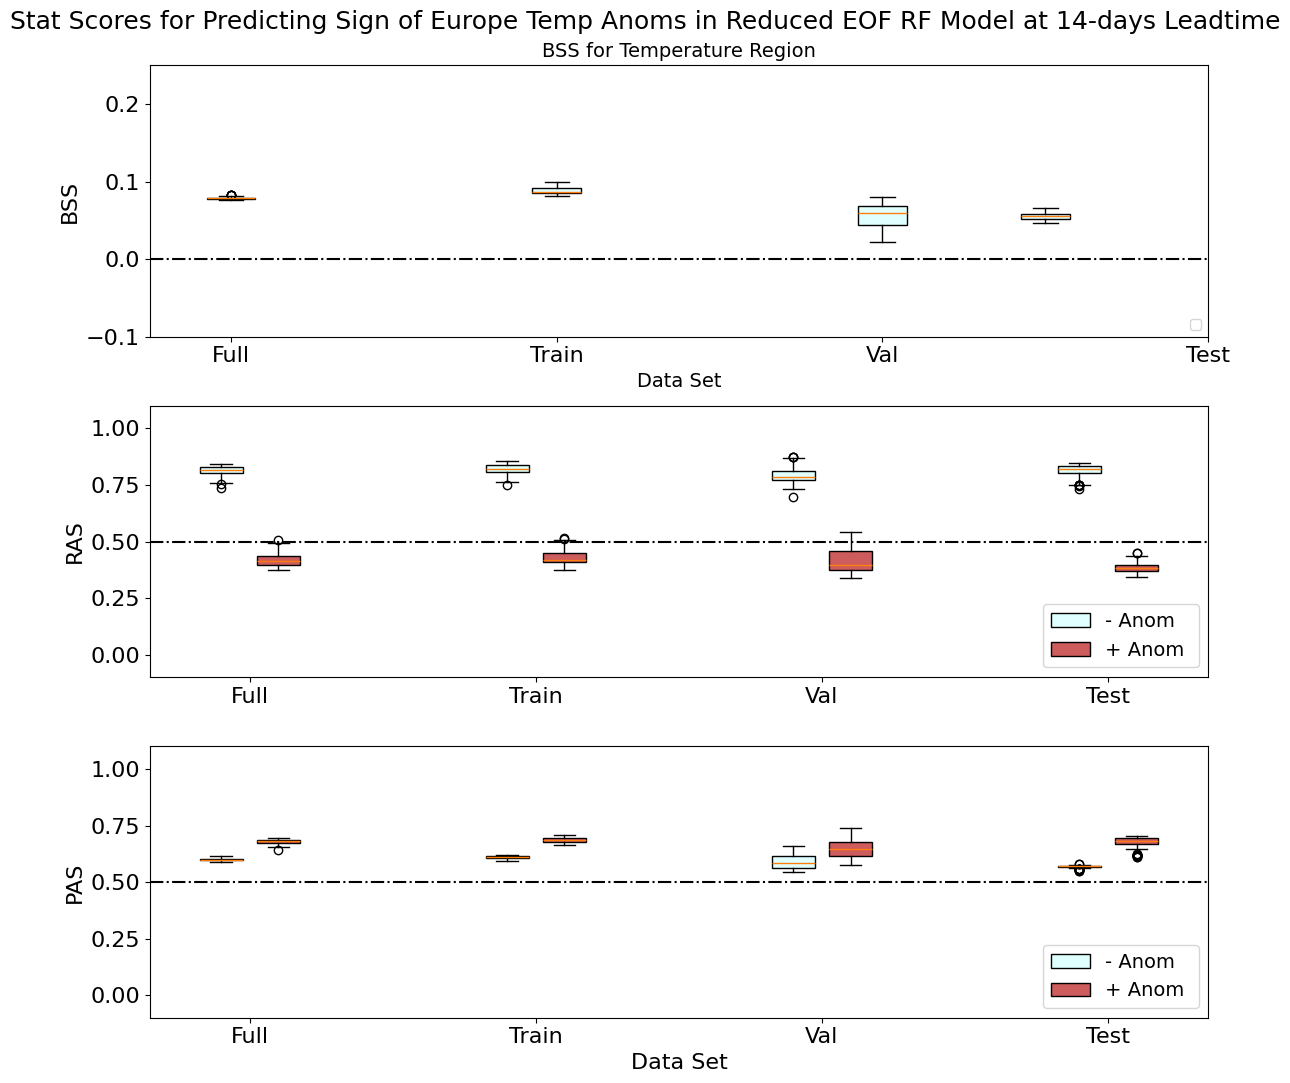

In [37]:
#plot
fig = plt.figure(figsize=(12,11))
font = 16
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','indianred']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.3 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
plt.suptitle("Stat Scores for Predicting Sign of Europe Temp Anoms in Reduced EOF RF Model at 14-days Leadtime",fontsize = 18) 

a1_0 = ax1.boxplot(BSS_all[:], positions= [2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot(BSS_train[:], positions=[4], widths=w, patch_artist=True)
a1_10 = ax1.boxplot(BSS_val[:], positions=[6], widths=w, patch_artist=True)
a1_14 = ax1.boxplot(BSS_test[:], positions=[7], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
#for patch, label in zip(a1_0['boxes'], labels):
    #patch.set_label(label)
ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-0.1,0.25)
ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 10)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 14)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 14)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("./images/RedEOFRF_14days_EurSS.png", bbox_inches='tight',dpi =150)


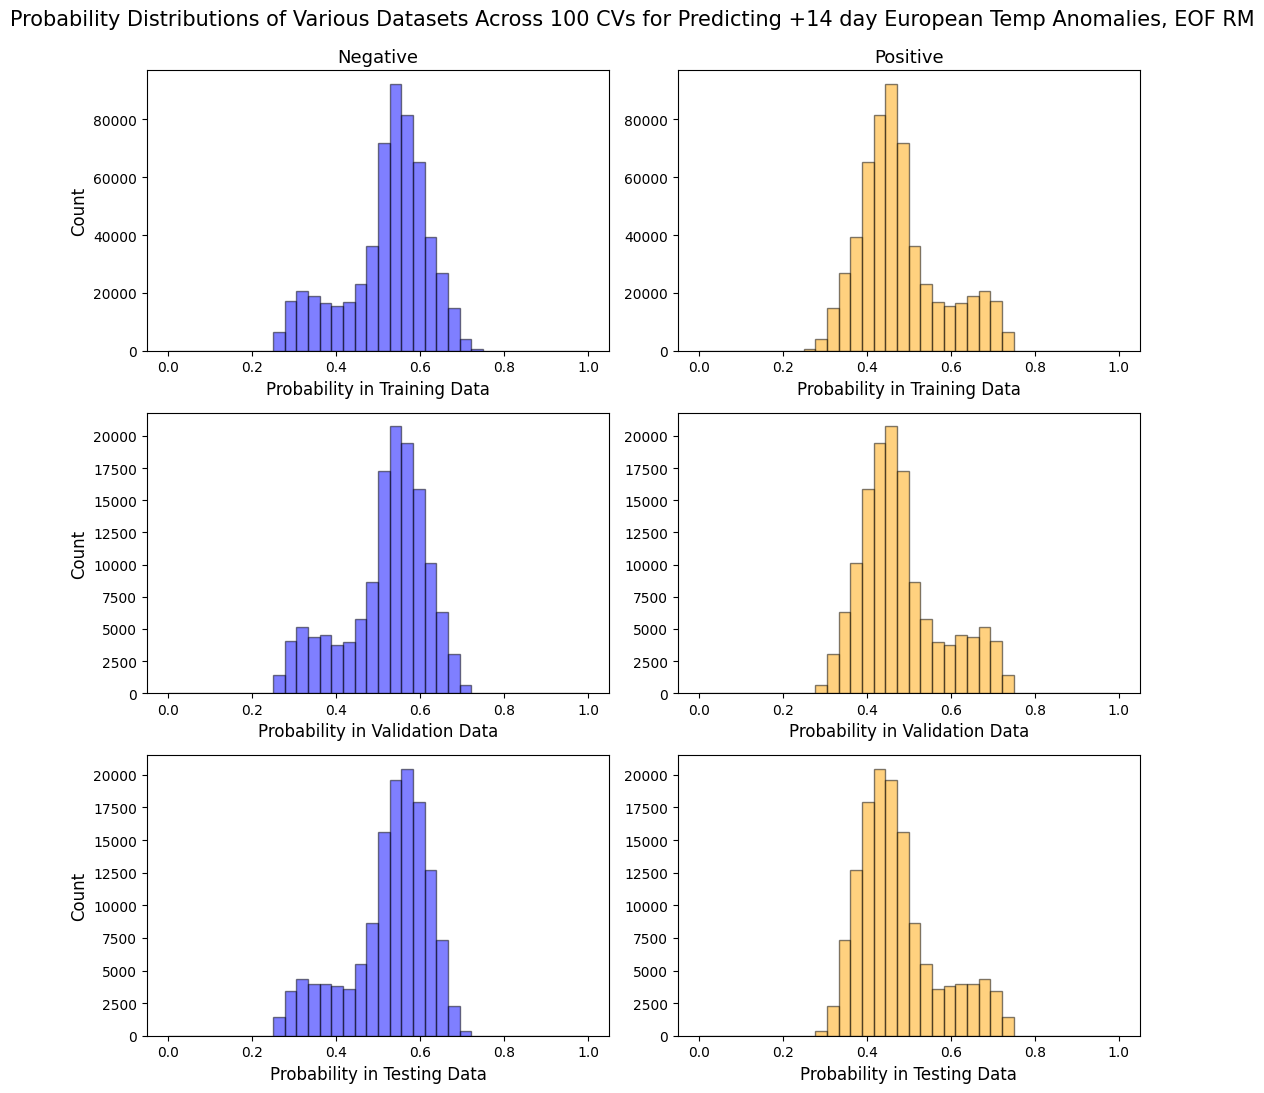

In [38]:
p_test = np.array(p_test)
p_test = p_test.reshape((len(p_test)*len(p_test[0]),2))

p_train = np.array(p_train)
p_train = p_train.reshape((len(p_train)*len(p_train[0]),2))

p_val= np.array(p_val)
p_val = p_val.reshape((len(p_val)*len(p_val[0]),2))

bins = np.linspace(0, 1, 37)  #10 bins from 0.4 to 1
fs = 11
##bin the probabilities
counts_neg_train, edges_neg_train = np.histogram(p_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(p_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(p_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(p_val[:,1], bins=bins)

counts_neg_test, edges_neg_test = np.histogram(p_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(p_test[:,1], bins=bins)


fig, axes = plt.subplots(3, 2, figsize=(11,11))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative', fontsize=fs+2)
ax1.set_xlabel('Probability in Training Data', fontsize=fs+1)
ax1.set_ylabel('Count', fontsize=fs+1)

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive', fontsize=fs+2)
ax2.set_xlabel('Probability in Training Data', fontsize=fs+1)
#ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax3.set_title('Negative Validation Predictions', fontsize=fs)
ax3.set_xlabel('Probability in Validation Data', fontsize=fs+1)
ax3.set_ylabel('Count', fontsize=fs+1)

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax4.set_title('Positive Validation Predictions', fontsize=fs)
ax4.set_xlabel('Probability in Validation Data', fontsize=fs+1)
#ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
#ax5.set_title('Negative Testing Predictions', fontsize=fs)
ax5.set_xlabel('Probability in Testing Data', fontsize=fs+1)
ax5.set_ylabel('Count', fontsize=fs+1)

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
#ax6.set_title('Positive Testing Predictions', fontsize=fs)
ax6.set_xlabel('Probability in Testing Data', fontsize=fs+1)
#ax6.set_ylabel('Count')

plt.suptitle("Probability Distributions of Various Datasets Across 100 CVs for Predicting +14 day European Temp Anomalies, EOF RM", fontsize=fs+4, x=0.525,y=0.99)
plt.tight_layout()
plt.savefig("./images/EurRF_probdistribRM_14days.png",bbox_inches = 'tight')

In [39]:
#try SHAP with this model
import shap

explainer = shap.TreeExplainer(rf_reg2)

In [40]:
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)

In [41]:
shap_obj.shape

(1350, 6, 2)

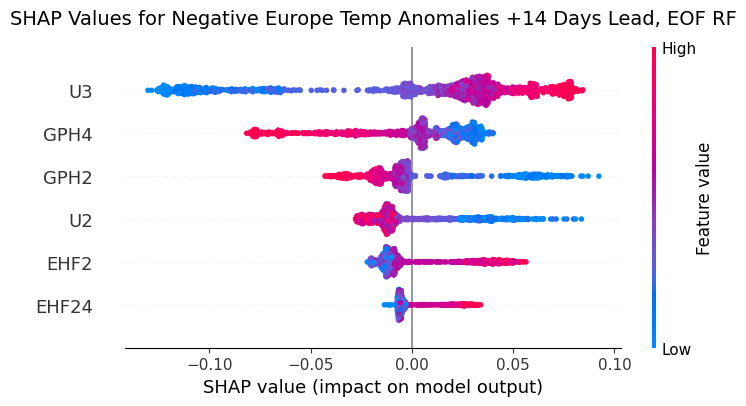

In [42]:
plt.title("SHAP Values for Negative Europe Temp Anomalies +14 Days Lead, EOF RF",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
#ax.set_xlim(-0.3,0.3)  
plt.savefig("./images/EOFRFshap_Eur_14days.png",bbox_inches = 'tight')

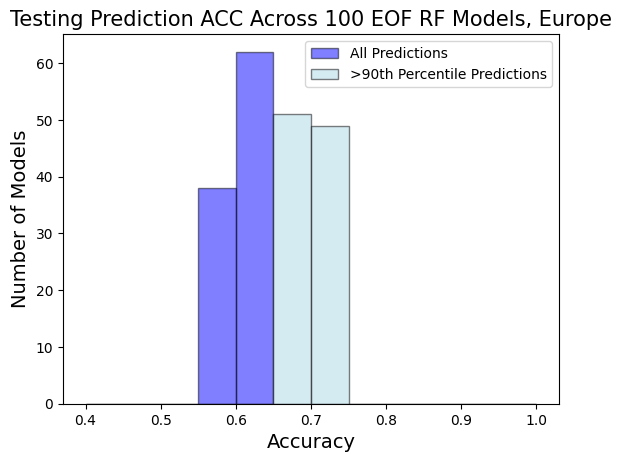

In [43]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =14)
plt.ylabel('Number of Models',fontsize =14)
plt.legend()
plt.title('Testing Prediction ACC Across 100 EOF RF Models, Europe',fontsize =15)
plt.savefig("./images/EurEOFRF_PredACCtest_14days.png",bbox_inches = 'tight')

In [44]:
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

indexes = np.array(indexes)

In [45]:
print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.mean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.mean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.mean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.mean(percpos)* 100 + np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.mean(percFpos)* 100 +np.mean(percFneg)* 100:.2f}%')

Average Num. of 10% Confident and Correct Postive Predictions: 39.28%
Average Num. of 10% Confident and Correct Negative Predictions: 30.76%
Average Num. of 10% Confident and FALSE Postive Predictions: 19.25%
Average Num. of 10% Confident and FALSE Negative Predictions: 10.72%
#######################################################################
Average Num. of 10% Confident and Correct Predictions: 70.03%
Average Num. of 10% Confident and FALSE Predictions: 29.97%


In [47]:
##export out files to make the next few plots w/o normalization
#pickle.dump(ranges, open("range_indices_RF14.p", 'wb'))
pickle.dump(posXtest, open("posXtest_eur14_eof.p", 'wb'))
pickle.dump(FposXtest, open("FposXtest_eur14_eof.p", 'wb'))
pickle.dump(negXtest, open("negXtest_eur14_eof.p", 'wb'))
pickle.dump(FnegXtest, open("FnegXtest_eur14_eof.p", 'wb'))